In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

2022-02-04 08:58:49.686512: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load and Preprocess Data

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

#### Only keep samples with current profiles that exceed 1 kA

In [4]:
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

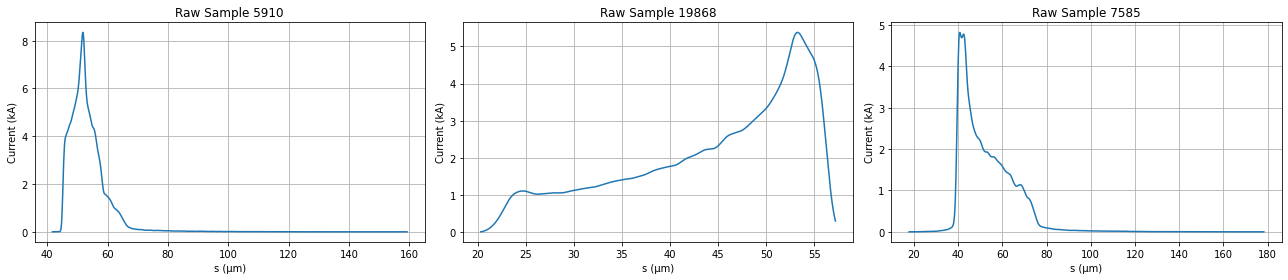

In [5]:
samples = np.random.randint(0, len(filtered), size=3)

plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Raw Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Compute lengths

In [6]:
def compute_max_left(current):
    revcurrent = np.flip(current)
    return np.flip(np.array([revcurrent[i:].max() for i in range(len(current))]))

def compute_max_right(current):
    return np.array([current[i:].max() for i in range(len(current))])

def find_edges(s, current, threshold=0.01):
    max_left = compute_max_left(current)
    left_idx = np.where(max_left >= threshold * max_left.max())[0][0]
    left = s[left_idx]
    
    max_right = compute_max_right(current)
    right_idx = np.where(max_right >= threshold * max_right.max())[0][-1]
    right = s[right_idx]
    
    return left, right

edges = np.array([find_edges(s, current) for s, current in filtered])
widths = edges[:,1] - edges[:,0]

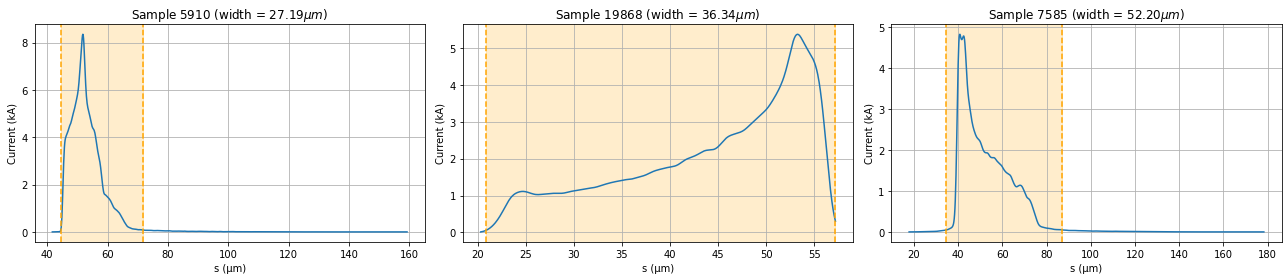

In [7]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    left, right = edges[sample]
    width = widths[sample]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample} (width = {width*1e6:.2f}$\mu m$)")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.axvspan(left*1e6, right*1e6, color="orange", alpha=0.2)
    plt.axvline(left*1e6, color="orange", ls="--")
    plt.axvline(right*1e6, color="orange", ls="--")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Interpolate into edges and center around 0

In [8]:
def resample(s, current, left, right, n=100):
    new_s = np.linspace(left, right, n)
    new_current = np.interp(new_s, s, current, left=0, right=0)
    return new_s, new_current

interpolated = [resample(s, current, left, right) for (s, current), (left, right) in zip(filtered, edges)]

In [9]:
def center_on_zero(s, current, left, right):
    old_center = left + ((right - left) / 2)
    new_s = s - old_center
    return new_s, current

recentered = [center_on_zero(s, current, left, right) for (s, current), (left, right) in zip(interpolated, edges)]

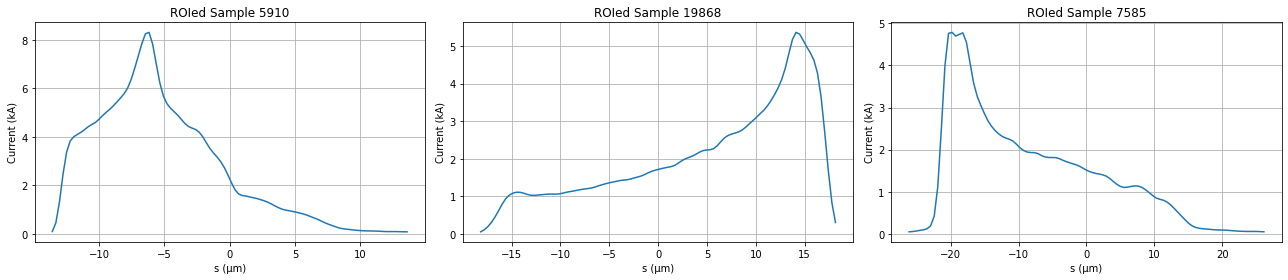

In [10]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = recentered[sample][0]
    current = recentered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"ROIed Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Make formfactors

In [11]:
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered])

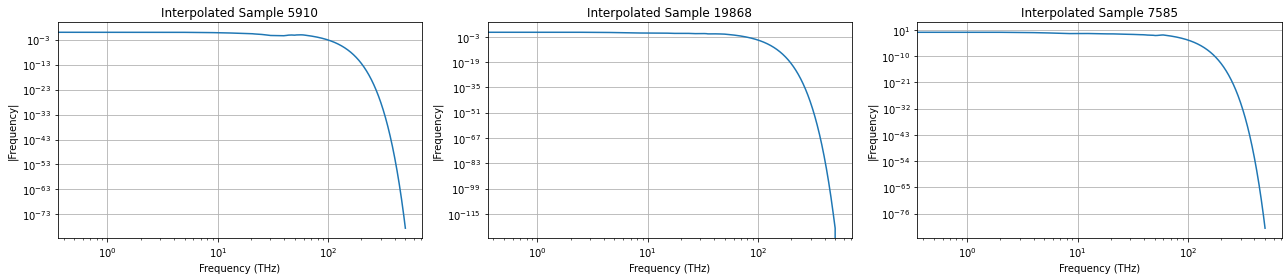

In [12]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    frequency = formfactors[sample][0]
    ff = formfactors[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.loglog(frequency*1e-12, ff, label="Formfactor")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("|Frequency|")
    plt.grid()
plt.tight_layout()
plt.show()

## Training

#### Train width predictor

2022-02-04 09:04:17.795331: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-04 09:04:17.800077: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-04 09:04:17.843370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-02-04 09:04:17.843421: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-04 09:04:19.312315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-04 09:04:19.312430: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

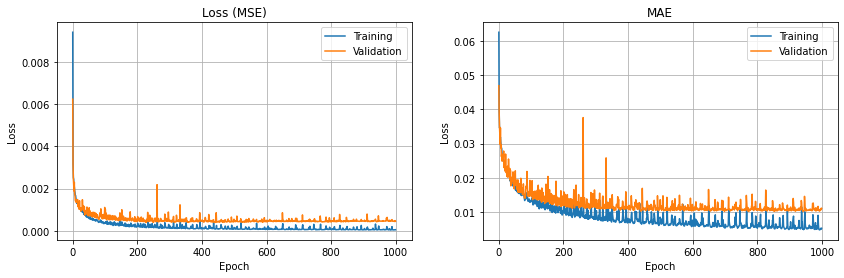

64/64 [==============================] - 0s 1ms/step - loss: 4.7435e-04 - mae: 0.0114
Mean deviation from true width = 2.09 microns


In [13]:
def plot_history(history):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title("Loss (MSE)")
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.subplot(122)
    plt.title("MAE")
    plt.plot(history.history["mae"], label="Training")
    plt.plot(history.history["val_mae"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_width_predictor(model, X_test, y_test, X_scaler, y_scaler):
    X_test_scaled = X_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)
    score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)
    m_delta = y_scaler.inverse_transform(np.array([score[1:]]).reshape(1,1)).squeeze() - widths.min()
    
    print(f"Mean deviation from true width = {m_delta * 1e6:.2f} microns")

def train_width_predictor(formfactors, widths, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = widths.reshape(-1, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y_train.shape[1])
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=64, validation_split=0.25, verbose=0)
    
    plot_history(history)
    evaluate_width_predictor(model, X_test, y_test, X_scaler, y_scaler)
    
    return model, X_scaler, y_scaler
                                            
wp, wp_X_scaler, wp_y_scaler = train_width_predictor(formfactors, widths, epochs=1000)

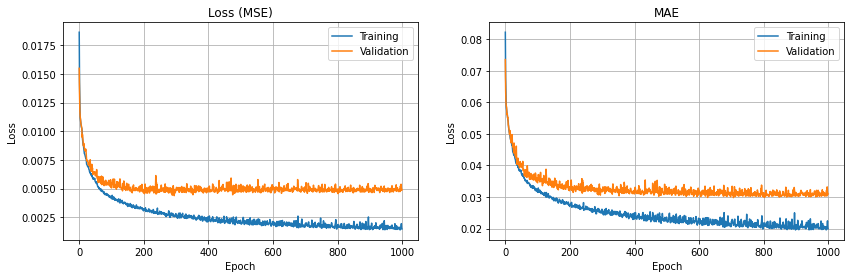

64/64 [==============================] - 0s 1ms/step - loss: 0.0045 - mae: 0.0294


In [14]:
def plot_history(history):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title("Loss (MSE)")
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.subplot(122)
    plt.title("MAE")
    plt.plot(history.history["mae"], label="Training")
    plt.plot(history.history["val_mae"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_current_predictor(model, X_test, y_test, X_scaler, y_scaler):
    X_test_scaled = X_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)
    score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)

def train_current_predictor(formfactors, currents, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = np.stack([current for _, current in currents])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    y_scaler = MinMaxScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y_train.shape[1], activation="relu")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=64, validation_split=0.25, verbose=0)
    
    plot_history(history)
    evaluate_current_predictor(model, X_test, y_test, X_scaler, y_scaler)
    
    return model, X_scaler, y_scaler
                                            
cp, cp_X_scaler, cp_y_scaler = train_current_predictor(formfactors, recentered, epochs=1000)

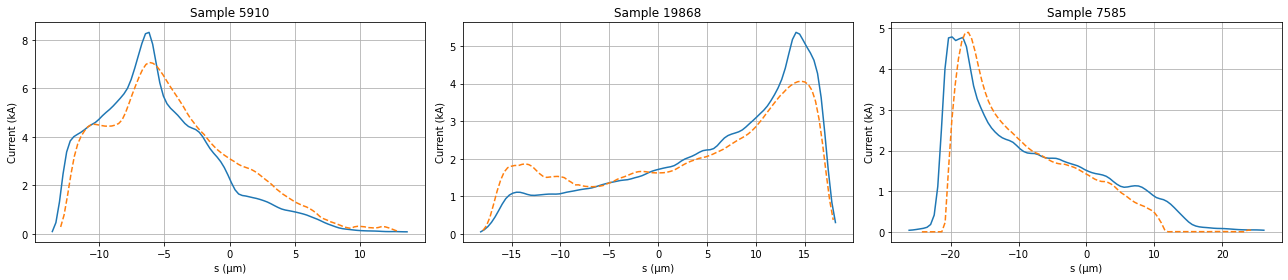

In [15]:
def do_prediction(formfactor, wp, wp_X_scaler, wp_y_scaler, cp, cp_X_scaler, cp_y_scaler):
    X = formfactor.reshape(1, -1)
    
    wp_X_scaled = wp_X_scaler.transform(X)
    wp_y = wp.predict(wp_X_scaled)
    width = wp_y_scaler.inverse_transform(wp_y).squeeze()
    s = np.linspace(-(width/2), width/2, 100)
    
    cp_X_scaled = cp_X_scaler.transform(X)
    cp_y = cp.predict(cp_X_scaled)
    current = cp_y_scaler.inverse_transform(cp_y).squeeze()
    
    return s, current


plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s_true = recentered[sample][0]
    current_true = recentered[sample][1]
    
    formfactor = formfactors[sample][1]
    s_predict, current_predict = do_prediction(formfactor, wp, wp_X_scaler, wp_y_scaler, cp, cp_X_scaler, cp_y_scaler)
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample}")
    plt.plot(s_true*1e6, current_true*1e-3, label="Ground Truth")
    plt.plot(s_predict*1e6, current_predict*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

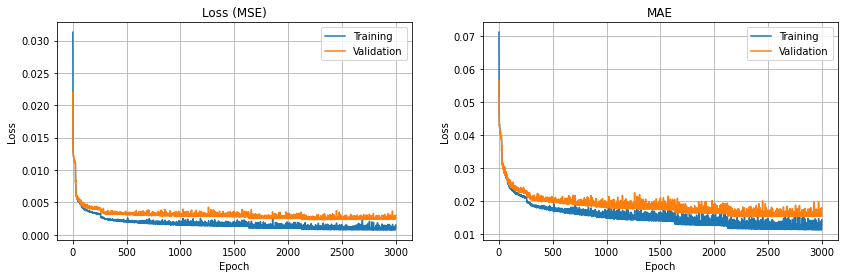

64/64 [==============================] - 0s 1ms/step - loss: 0.0032 - mae: 0.0183


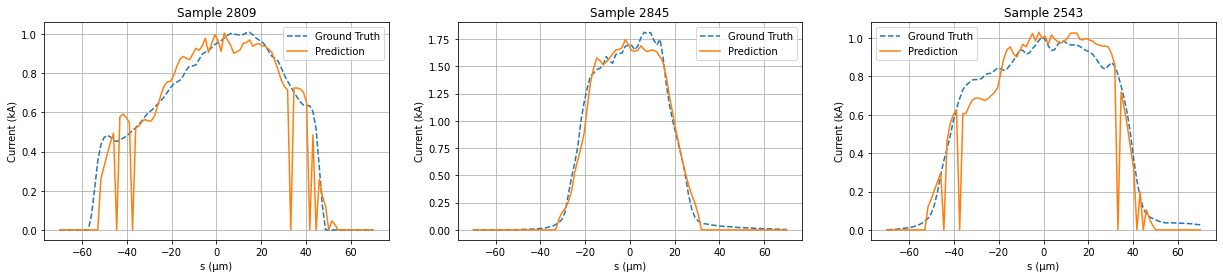

INFO:tensorflow:Assets written to: models/model/assets


In [32]:
model, X_scaler, y_scaler = train(formfactors, interpolated, epochs=3000)
model.save("models/model")
scalers = {"X": X_scaler, "y": y_scaler}
with open("models/scalers.pkl", "wb") as f:
    pickle.dump(scalers, f)